In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import scipy.optimize as opt
import scipy.integrate as integ
import scipy.linalg as la

import astropy.io as io 
import astropy.units as u
import specutils as spu

import DMdecayJWST as assume
import JWSTparsedatafiles as JWSTparse 
import MWDMhalo as mw
import conversions as convert 

In [2]:
full_data, full_targets = JWSTparse.process_target_list(assume.data_dir)

found 377 datafiles
parsing...
done



In [40]:
data  = [d for d  in full_data if d["name"] == "GN-z11"][1]
target  = [t for t  in full_targets if t["name"] == "GN-z11"][1]

In [41]:
data

{'lam': array([1.66052997, 1.66158997, 1.66264997, ..., 3.16785002, 3.16891002,
        3.16997002]),
 'sky': array([0.17215958, 0.17181851, 0.16476989, ..., 0.03401792, 0.02775385,
        0.02199137]),
 'error': array([0.00154223, 0.001742  , 0.00161864, ..., 0.00143556, 0.00180074,
        0.00493607]),
 'grating': 'G235M',
 'name': 'GN-z11',
 'D': 2.768057132054331,
 'max_res': 0.002355027012526989}

In [42]:
target

name,ra,dec,instrument,detector,filter,grating,int_time,lambda_min,lambda_max,path,b,l,D
str31,float64,float64,str7,str8,str6,str5,float64,float64,float64,str111,float64,float64,float64
GN-z11,189.1060420833333,62.24204166666667,NIRSPEC,NRS1,F170LP,G235M,1896.5557,1.6605299666407518,3.169970021757763,data/mastDownload/JWST/jw04426-o001_t001_nirspec_g235m-f170lp/jw04426-o001_t001_nirspec_g235m-f170lp_x1d.fits,54.79774431840697,125.96364875475768,2.768057132054331


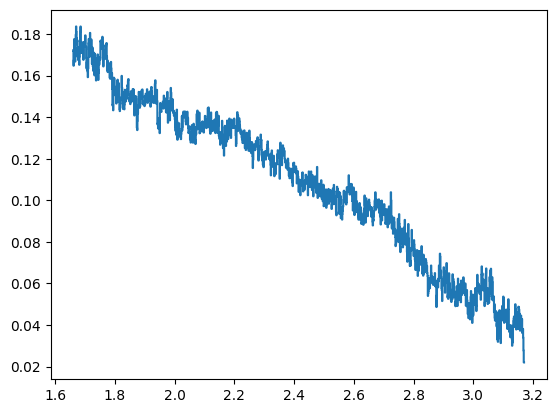

In [43]:
fig, ax = plt.subplots()
ax.step(data["lam"], data["sky"])

(0.08, 0.2)

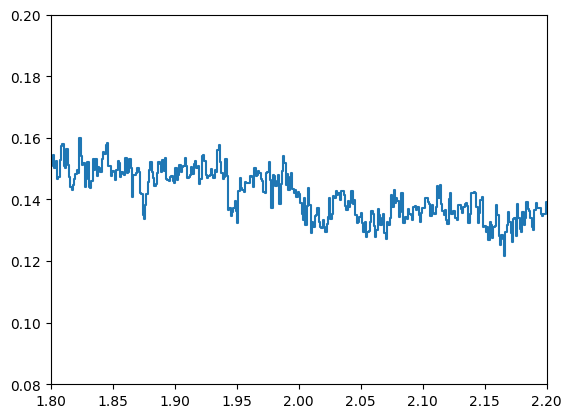

In [188]:
fig, ax = plt.subplots()
ax.step(data["lam"], data["sky"], where="mid")
ax.set_xlim(1.8, 2.2)
ax.set_ylim(.08, .2)

In [8]:
def linear(p, x):
    x = np.asarray(x)
    p = np.asarray(p)
    return p[0] + p[1]*x

def quadratic(p, x):
    x = np.asarray(x)
    p = np.asarray(p)
    return p[0] + p[1]*x + p[2]*(x**2)

def cubic(p, x):
    x = np.asarray(x)
    p = np.asarray(p)
    return p[0] + p[1]*x + p[2]*(x**2) + p[3]*(x**3)

def Mi(a, b, n):
    return (b**n - a**n)/n

def weighted_residual(p, x, y, sigma_y, model):
    return (model(p, x) - y)/sigma_y

In [15]:
dm_line = lambda rate, lam: mw.MWDecayFlux(lam, lam0,
                                      rate, data["D"], 
                                      data["max_res"])

In [17]:
cubic_plus_line = lambda p, x: cubic(p[:4], x) + dm_line(p[4], x)

In [274]:
lam0 = 1.7
v_dm = 10**(-3)
window_factor = 200
lam_start = lam0*(1 - window_factor*0.5*v_dm) 
lam_end = lam0*(1 + window_factor*0.5*v_dm)
print(lam_end - lam_start)

0.3400000000000001


In [275]:
select = (lam_start < data["lam"]) & (data["lam"] < lam_end)
flux = data["sky"][select]
lam = data["lam"][select]
sigma_flux = 2*data["error"][select]

In [276]:
I0 = integ.simpson(flux, lam)
I1 = integ.simpson(flux*lam, lam)
I2 = integ.simpson(flux*(lam**2), lam)
I3 = integ.simpson(flux*(lam**3), lam)
n_max = (3)*2 + 1
Mi_s = Mi(lam[0], lam[-1], range(1, n_max + 1))
M = np.array([[Mi_s[0], Mi_s[1], Mi_s[2], Mi_s[3]],
              [Mi_s[1], Mi_s[2], Mi_s[3], Mi_s[4]],
              [Mi_s[2], Mi_s[3], Mi_s[4], Mi_s[5]],
              [Mi_s[3], Mi_s[4], Mi_s[5], Mi_s[6]]])
g = la.solve(M, [I0, I1, I2, I3])
print(g)

[-53.36272766  90.57961563 -50.97359618   9.53885234]


In [277]:
sol_g = opt.least_squares(weighted_residual, g,
                  args=(lam, flux, sigma_flux, cubic),
                  loss='huber', f_scale=0.1)
sol_hard = opt.least_squares(weighted_residual, g,
                  args=(lam, flux, sigma_flux, cubic))
best=sol_g["x"]
chisq_dof = 2*sol_g["cost"]/(lam.size - best.size)
print(sol_g["x"])
print(chisq_dof)

[-53.31192641  90.35512847 -50.76707054   9.48484243]
0.3184306036115574


(0.1, 0.2)

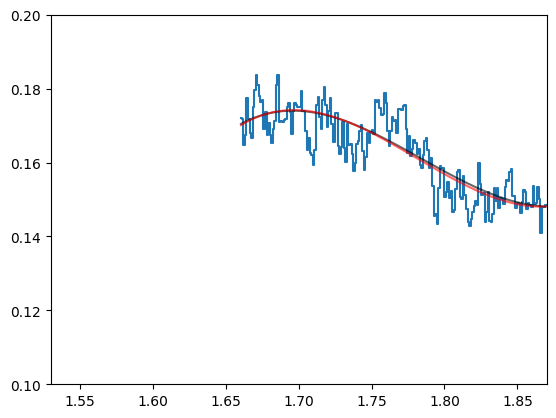

In [283]:
fig, ax = plt.subplots()
ax.step(lam, flux, where="mid")
ax.plot(lam, quadratic(g, lam), 
        color='r', linestyle="dotted", marker='', alpha=0.4)
ax.plot(lam, cubic(best, lam), 
        color='k', linestyle="solid", marker='', alpha=0.6)
ax.plot(lam, cubic(sol_hard["x"], lam), 
        color='r', linestyle="solid", marker='', alpha=0.6)
ax.set_xlim(lam_start, lam_end)
ax.set_ylim(.1,.2)

(-0.04, 0.04)

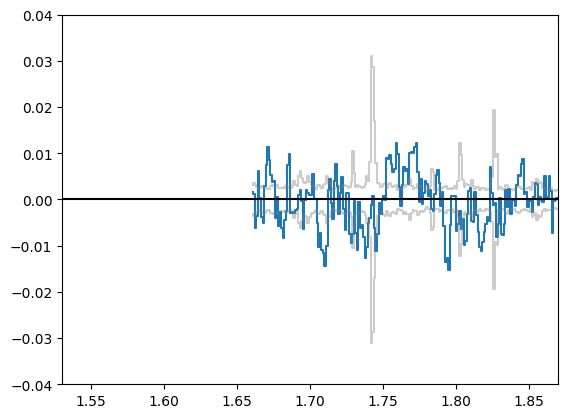

In [284]:
fig, ax = plt.subplots()
ax.step(lam, flux-cubic(best, lam), where="mid")
ax.step(lam, sigma_flux, where="mid", color="gray", alpha=0.4)
ax.step(lam, -sigma_flux, where="mid", color="gray", alpha=0.4)
ax.axhline(0.0, color='k')
ax.set_xlim(lam_start, lam_end)
ax.set_ylim(-.04, .04)

(-0.03, 0.05)

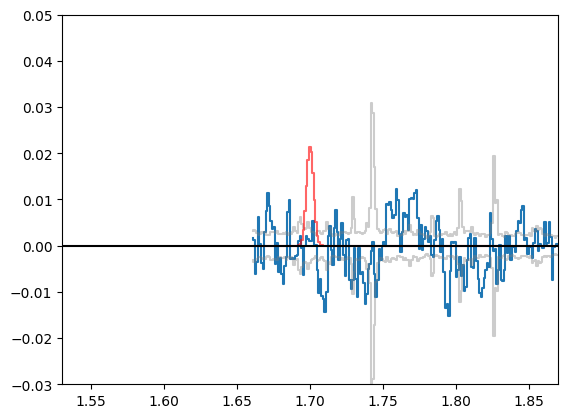

In [285]:
decay_rate = 2e-4

fig, ax = plt.subplots()
ax.step(lam, flux-cubic(best, lam), where="mid")
ax.step(lam, sigma_flux, where="mid", color="gray", alpha=0.4)
ax.step(lam, -sigma_flux, where="mid", color="gray", alpha=0.4)
ax.step(lam, dm_line(decay_rate, lam), where="mid", 
        color='r', linestyle='-', marker='', alpha=0.6)
ax.axhline(0.0, color='k')
ax.set_xlim(lam_start, lam_end)
ax.set_ylim(-.03,.05)

In [286]:
g_line = np.concatenate((g, [0]))

sol_g_line = opt.least_squares(weighted_residual, g_line,
                args=(lam, flux, sigma_flux, cubic_plus_line),
                loss='soft_l1', f_scale=0.1)
best_line =sol_g_line["x"]
chisq_dof_line  = 2*sol_g_line["cost"]/(lam.size - best_line.size)
print(best_line)
print(chisq_dof_line)

[-5.84962847e+01  9.88792260e+01 -5.54369401e+01  1.03372952e+01
  2.66809322e-05]
0.30989435829124434


(-0.02, 0.02)

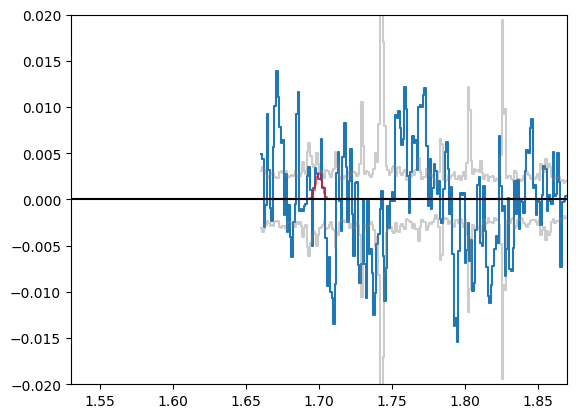

In [287]:
fig, ax = plt.subplots()
ax.step(lam, flux-cubic(best_line[:4], lam), where="mid")
ax.step(lam, sigma_flux, where="mid", color="gray", alpha=0.4)
ax.step(lam, -sigma_flux, where="mid", color="gray", alpha=0.4)
ax.step(lam, dm_line(best_line[4], lam), where="mid", 
        color='r', linestyle='-', marker='', alpha=0.6)
ax.axhline(0.0, color='k')
ax.set_xlim(lam_start, lam_end)
ax.set_ylim(-.02,.02)

In [235]:
chisq_dof_func = lambda dr: np.sum(weighted_residual(
    list(best_line[:4]) + [dr], 
    lam, flux, sigma_flux, cubic_plus_line)**2)/(lam.size - g_line.size)

delta_chisq_dof_func = lambda dr: chisq_dof_func(dr) - chisq_dof_func(best_line[4]) - 4

In [288]:
print(chisq_dof_line)
print(chisq_dof_func(best_line[4]))
print(delta_chisq_dof_func(best_line[4]))

0.30989435829124434
4.742792474044419
-4.0


In [289]:
sol = opt.root_scalar(delta_chisq_dof_func, bracket=[0, 1e-3])
print(sol.root)

0.00048184472645511263


(-0.02, 0.1)

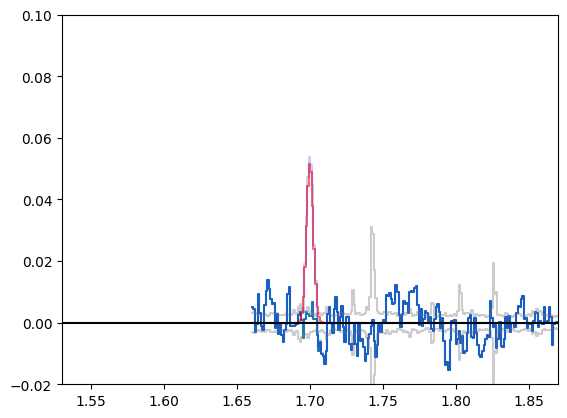

In [291]:
fig, ax = plt.subplots()
ax.step(lam, flux-cubic(best_line[:4], lam), where="mid")
ax.step(lam, sigma_flux, where="mid", color="gray", alpha=0.4)
ax.step(lam, -sigma_flux, where="mid", color="gray", alpha=0.4)
ax.step(lam, dm_line(sol.root, lam), where="mid", 
        color='r', linestyle='-', marker='', alpha=0.6)
ax.step(lam, 
        flux - cubic(best_line[:4], lam) + dm_line(sol.root, lam), 
        where="mid", color='b', 
        linestyle='-', marker='', alpha=0.2)
ax.axhline(0.0, color='k')
ax.set_xlim(lam_start, lam_end)
ax.set_ylim(-.02,.1)

In [292]:
m = convert.wavelength_to_mass(lam0)
print("{} eV".format(m))
limit_decayrate = convert.fluxscale_to_invsec(sol.root, assume.rho_s, assume.r_s)    
print("{} 1/sec".format(limit_decayrate))
limit_g = convert.decayrate_to_axion_g(limit_decayrate, m)  
print("{} GeV^-1".format(limit_g))

1.4470588235294117 eV
6.614211175645412e-26 1/sec
5.4089065562316625e-11 GeV^-1


In [184]:
window_factor*v_dm*np.median(data["lam"])

0.14491499965195542

In [295]:
(15*0.1*3*10**7/1900)**(0.25)

12.405513000790137